# Assignment 1

FEUP Mar 2023 - Computer Vision (CV) curricular unit

Team members:
 - Nicholas Hopf
 - Rodrigo Gomes
 - Rui Colaço

## Context

The quality assurance tester of a M&M factory retrieves a sample from the production every hour to determine some properties of chocolate peanuts. The factory uses a computer vision application to automatically calculate some properties of the sample, namely:

 - the distribution of each color in the sample, e.g., the number of red (or blue or …) chocolates. At the end, if the sample does not have chocolate peanuts of all colors, the system must raise an alarm by printing "Color XPTO is missing".

 - the average shape area of all chocolate peanuts in millimeters and organized by color.

> TODO: Add base64 image here

Considering these requirements:

a) Calibrate the intrinsic parameters and lens distortion of the camera. Show the intrinsic matrix and the lens distortion coefficients.

In [1]:
# Import dependencies
import numpy as np
import cv2
import glob

%matplotlib inline
from matplotlib import pyplot as plt

# Disclaimer: this code was partly inspired by the following sources
# A set of scripts that *I wrote* and made publicly available in 2020 on GitHub https://github.com/nhpf/opencv-classes
# The official OpenCV documentation https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html

# Calibration criteria. We perform 30 iterations with 0.001 subpixel precision
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)


def calibrate(is_extrinsic, square_size_mm=22, width=7, height=4):
    """Takes images from IntrinsicCalibration directory and returns calibration parameters K, D"""
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,3,0)
    objp = np.zeros((height * width, 3), np.float32)
    objp[:, :2] = np.mgrid[0:width, 0:height].T.reshape(-1, 2)

    # Scale the board to real size in millimeters
    if is_extrinsic:
        objp = objp * square_size_mm

    # Lists to store points of each image
    objpoints = []  # 3d image points
    imgpoints = []  # 2d points at the chessboard plane

    # Iterate over the calibration images
    images = glob.glob("./IntrinsicCalibration/*.png")
    for fname in images:
        # Reads each image and converts it into grayscale
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (width, height), None)

        # If found
        if ret:
            # Adds 3d points to objpoints list
            objpoints.append(objp)

            # Adjusts the detected chessboard corners according to precision criteria
            corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
            # Adds the adjusted corners to imgpoints list
            imgpoints.append(corners2)

            # This function draws the chessboard corners - used only for debugging
            # img = cv2.drawChessboardCorners(img, (width, height), corners2, ret)

    # Use the function calibrateCamera to generate correction matrix
    _, mtx, dist, _, _ = cv2.calibrateCamera(
        objpoints, imgpoints, gray.shape[::-1], None, None
    )
    return mtx, dist


mtx, dist = calibrate(is_extrinsic=False, square_size_mm=22, width=7, height=4)

# Print the results
np.set_printoptions(precision=3, suppress=True)
print("Intrinsic Matrix = ")
print("\t" + str(mtx).replace("\n", "\n\t"))
print("\nLens Distortion coefficients =\n\t", dist)

Intrinsic Matrix = 
	[[1321.65     0.     988.3  ]
	 [   0.    1324.446  642.259]
	 [   0.       0.       1.   ]]

Lens Distortion coefficients =
	 [[-0.344  0.09   0.    -0.    -0.003]]


With the script above we were able to calculate the intrinsic matrix $K$ in **pixel units**, where each matrix element corresponds to:

 - $(c_x, c_y)$ as the pixel coordinates of the camera optical center.
 - $(f_x, f_y)$ as two focal lengths since pixels in the imaging sensor may not be square.
 - $\gamma$ is a small skew between the x and y axes of the camera sensor.

Presented in the format:
$$K = \begin{bmatrix}f_x & \gamma & c_x\\ 0 & f_y & c_y\\ 0 & 0 & 1\end{bmatrix}$$

While we also obtained the value of the distortion coefficients:

 - $(k_1, k_2, k_3)$ that represent the radial distortion
 - $(p_1, p_2)$ that represent the tangential distortion

Presented in the format:
$$D = \begin{bmatrix}k_1 & k_2 & p_1 & p_2 & k_3\end{bmatrix}$$

b) Calibrate the extrinsic parameters of the camera setup (or instead, use the extrinsic image to manually measure the dimensions of a black square of the chessboard in pixels. In this way, you will know the conversion between pixel to millimeter). Show the extrinsic matrix (rotation, translation, etc) and/or the conversion ratio between pixel to millimeter that was used.

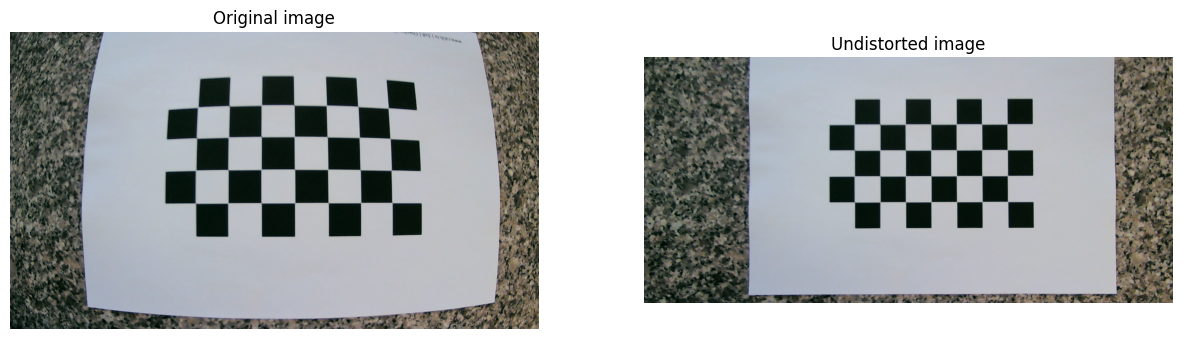

Each millimiter has 3.6403 pixels.

Extrinsic Matrix = 
	[[363.062   0.    271.489]
	 [  0.    363.83  176.431]
	 [  0.      0.      0.275]]


In [7]:
# Function that will help us here and in the questions below
def undistort_and_get_roi(K, D, fname, apply_paper_roi=True):
    img = cv2.imread(fname)

    # Obtain matrix that will allow us to undistort the images captured by the camera
    h, w = img.shape[:2]
    new_camera_mtx, roi = cv2.getOptimalNewCameraMatrix(K, D, (w, h), 1, (w, h))

    # mapx, mapy are the correction factors that will be applied in each image to eliminate distortion
    mapx, mapy = cv2.initUndistortRectifyMap(K, D, None, new_camera_mtx, (w, h), 5)

    # Returns the undistorted image
    corr = cv2.remap(img, mapx, mapy, cv2.INTER_LINEAR)

    # Limit the image according to undistorted area of interest
    x, y, w, h = roi
    corr = corr[y : y + h, x : x + w]

    # Limit the ROI to the inside of a white sheet of paper on the image
    if apply_paper_roi:
        # Remove salt-and-pepper noise from background
        without_sp = cv2.medianBlur(corr, ksize=35)

        # Binarize the image - gray pixels between 150 and 255 are considered to be white
        gray = cv2.cvtColor(without_sp, cv2.COLOR_RGB2GRAY)
        _, binary = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)

        # Get bounding rect for white pixels (paper)
        paper_points = cv2.findNonZero(binary)
        y, x, h, w = cv2.boundingRect(paper_points)

        # Add a 20px margin in each side to get a definive ROI
        epsilon = 20
        corr = corr[x + epsilon : x+w-epsilon, y+epsilon:y+h-epsilon]

    return corr


# Calculate size of each square in pixels
def get_square_size_in_px():
    original_img = cv2.imread("./WhiteBackground/extrinsic.png")
    undistorted_img = undistort_and_get_roi(
        mtx, dist, "./WhiteBackground/extrinsic.png", apply_paper_roi=False
    )

    # Display images using plt
    plt.figure(figsize=(15, 15))
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    plt.title("Original image")
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB))
    plt.title("Undistorted image")
    plt.axis("off")
    plt.show()

    # Convert undistorted image to grayscale for corner detection
    gray_img = cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    chessboard_w, chessboard_h = 7, 4
    _, corners = cv2.findChessboardCorners(gray_img, (chessboard_w, chessboard_h), None)

    # Adjust position of corners according to precision criteria previously indicated
    corners = cv2.cornerSubPix(gray_img, corners, (11, 11), (-1, -1), criteria)

    # List to store the Euclidean distance between each pair of points
    distances = []

    # Iterate through the detected chessboard corners
    corner_mtx = corners.reshape(chessboard_h, chessboard_w, -1)
    for row in corner_mtx:
        for corner_l, corner_r in zip(row, row[1:]):
            # Add distance between neighboring corners to the list
            distances.append(np.linalg.norm(corner_r - corner_l))

    # Return average square size in pixels
    return sum(distances) / len(distances)


square_size_px = get_square_size_in_px()

# Use square_size = 22mm by inspecting the calibration images
square_size_mm = 22

px_mm_ratio = square_size_px / square_size_mm
mm_px_ratio = square_size_mm / square_size_px
print(f"Each millimiter has {px_mm_ratio:.4f} pixels.")

# Print the extrinsic matrix
np.set_printoptions(precision=3, suppress=True)
print("\nExtrinsic Matrix = ")
print("\t" + str((square_size_mm / square_size_px) * mtx).replace("\n", "\n\t"))

Using the intrinsic camera matrix and distortion coefficients determined in the previous step, now we were able to revert the image distortion (radial distortion curved inwards, same as barrel distortion) as shown above.

After that, we estimated the average distance in pixels between the chessboard corners detected by OpenCV in the undistorted image.
It is approximately equal to $80.38$ pixels.

Inspecting the calibration images, we were able to identify that each square side has $22\text{ mm}$ in length.

Therefore, the millimeter-pixel ratio that will be used is approximately equal to $3.64$ pixels per millimeter.

Finally, we obtained the extrinsic camera matrix by simply converting each pixel value determined previously to millimeters using the calculated ratio.


c) Consider only the images retrieved from a White Background. Implement the functions described above.
1. Define a ROI (region of interest) for the image;
2. Calculate the number of M&M per color for all images provided;
3. Determine the average area for peanuts in pixels, considering the image "calib_img 3";
    1. Show all peanuts that were detected.
    2. Discuss the limitations of the peanut detection method used (in 2 sentences).
4. Determine the average area (and standard deviation) for peanuts in millimeters and grouped by color, considering images "calib_img_2" and "calib_img 3".
    1. Show the result in a table color vs area and standard deviation.
    2. Discuss the limitation of the method implemented (in 2 sentences).
5. Provide some recommendations that the M&M factory should take into consideration to improve the performance of the quality assurance process based on image processing (e.g., imaging setup, calibration process and photometric effects), in 4 sentences.

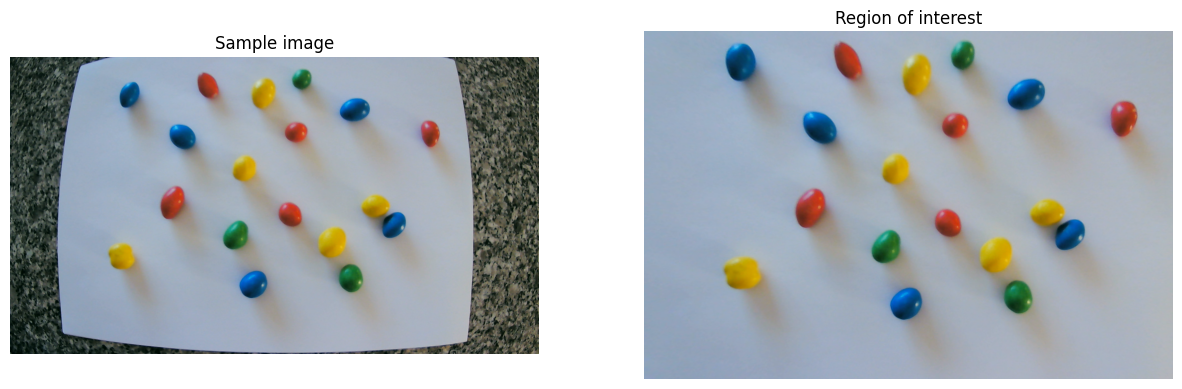

In [8]:
# Step 1 - undistort image and apply ROI as previously defined
path_white_3 = "./WhiteBackground/calib_img 3.png"
img_white_3 = cv2.imread(path_white_3)
roi_white_3 = undistort_and_get_roi(mtx, dist, path_white_3, apply_paper_roi=True)

# Display images using plt
plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.imshow(cv2.cvtColor(img_white_3, cv2.COLOR_BGR2RGB))
plt.title("Sample image")
plt.axis("off")
plt.subplot(122)
plt.imshow(cv2.cvtColor(roi_white_3, cv2.COLOR_BGR2RGB))
plt.title("Region of interest")
plt.axis("off")
plt.show()


Sample 1:
	5 blue peanuts
	3 green peanuts
	5 yellow peanuts
	4 red peanuts

Sample 2:
	No peanuts were found

Sample 3:
	4 blue peanuts
	4 yellow peanuts
	5 red peanuts

Sample 4:
	4 blue peanuts
	4 yellow peanuts


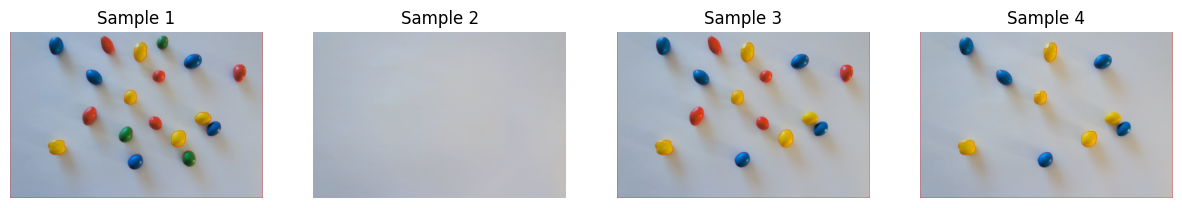

In [9]:
# Step 2 - use watershed algorithm to count the peanuts
def get_number_of_peanuts(M, K, fname):
    # Get corrected image limited to its region of interest
    img = undistort_and_get_roi(M, K, fname)

    # Soften light spots and shadows
    blurred = cv2.bilateralFilter(img, d=12, sigmaColor=10, sigmaSpace=10)

    # Binarize image with automatic threshold
    gray = cv2.cvtColor(blurred, cv2.COLOR_RGB2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Remove black gaps inside image
    kernel = np.ones((3, 3), np.uint8)
    closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=3)

    # Get central part of each peanut based on distance from other peanuts
    img_distance = cv2.distanceTransform(closing, cv2.DIST_L2, 3)
    _, img_distance = cv2.threshold(img_distance, 0.63 * img_distance.max(), 255, 0)

    # Define black image to hold peanut contours
    peanut_markers = np.zeros(img_distance.shape, dtype=np.int32)

    # Find peanut contours
    contours, _ = cv2.findContours(
        img_distance.astype("uint8"), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    # Draw the contours in the black image
    for i in range(len(contours)):
        cv2.drawContours(peanut_markers, contours, i, (i + 1), -1)

    # Apply the waterhsed algorithm to make contours expand to the edge of each peanut
    peanut_markers = cv2.watershed(img, peanut_markers)

    # Show markers over original image
    marked_image = img.copy()
    marked_image[peanut_markers == -1] = [0, 0, 255]

    # Dictionary that will store peanut data found for each color
    peanut_color_classes = {}

    # Iterate through all peanuts
    num_peanuts = 0
    for label in np.unique(peanut_markers):
        if label == 0:
            continue

        # Create a mask for the peanut
        mask = np.zeros(gray.shape, dtype="uint8")

        # Assign pixels as white inside peanut region
        mask[peanut_markers == label] = 255

        # Find contours of that mask
        peanut_contours = cv2.findContours(
            mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
        peanut_contours = (
            peanut_contours[0] if len(peanut_contours) == 2 else peanut_contours[1]
        )

        # For each contour
        for cnt in peanut_contours:
            # If it has a reasonable size for a peanut
            if (cv2.contourArea(cnt) > 30) and (cv2.contourArea(cnt) < 5000):
                # Calculate its area
                peanut_area = cv2.contourArea(cnt)

                # Get the inner part of the contour
                x, y, w, h = cv2.boundingRect(cnt)
                epsilon = 15
                x += epsilon
                y += epsilon
                w -= 2 * epsilon
                h -= 2 * epsilon

                # Determine the color of the inner part of the peanut
                p_color = classify_color(img[y : y + h, x : x + w])
                num_peanuts += 1

                # Add one to corresponding color in dictionary
                if p_color in peanut_color_classes:
                    peanut_color_classes[p_color]["num_peanuts"] += 1
                    peanut_color_classes[p_color]["areas"].append(peanut_area)
                else:
                    peanut_color_classes[p_color] = {}
                    peanut_color_classes[p_color]["num_peanuts"] = 1
                    peanut_color_classes[p_color]["areas"] = [peanut_area]

    if num_peanuts > 0:
        return marked_image, peanut_color_classes

    return img, peanut_color_classes


# Function that returns the color name will help us here and in the questions below
def classify_color(peanut_img):
    # Get the average H, S, V values for the given image
    peanut_img_hsv = cv2.cvtColor(peanut_img, cv2.COLOR_BGR2HSV)
    avg_color = np.array(cv2.mean(peanut_img_hsv)).astype(np.uint8)[:3]

    # Reference color values
    hsv_color_dict = {
        "red": np.asarray([4.9, 207.3, 171.1]),
        "yellow": np.asarray([22.6, 238.9, 188.9]),
        "green": np.asarray([63.9, 163.9, 83.9]),
        "blue": np.asarray([104.7, 240.7, 161.9]),
    }

    # Compute the Euclidean distance between the average color and each reference color
    color_labels = list(hsv_color_dict.keys())
    distances = [
        np.linalg.norm(hsv_color_dict[color_label] - avg_color)
        for color_label in color_labels
    ]

    # The classified color will be the one that has the minimum distance
    peanut_color = color_labels[distances.index(min(distances))]
    return peanut_color


# Prepare figure in which the images will be shown
plt.figure(figsize=(15, 15))

# Iterate over the calibration images
img_paths = glob.glob("./WhiteBackground/calib_img*.png")
for img_idx, img_path in enumerate(img_paths):
    # Call peanut counter function
    marked_img, color_classes = get_number_of_peanuts(mtx, dist, img_path)

    # Show number of peanuts by color
    print(f"\nSample {img_idx + 1}:")
    for color_name in color_classes.keys():
        print(f"\t{color_classes[color_name]['num_peanuts']} {color_name} peanuts")

    # Alert user when no peanuts were identified
    if len(color_classes.keys()) == 0:
        print("\tNo peanuts were found")

    # Display images using plt
    plt.subplot(100 + len(img_paths) * 10 + img_idx + 1)
    plt.imshow(cv2.cvtColor(marked_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Sample {img_idx + 1}")
    plt.axis("off")

plt.show()

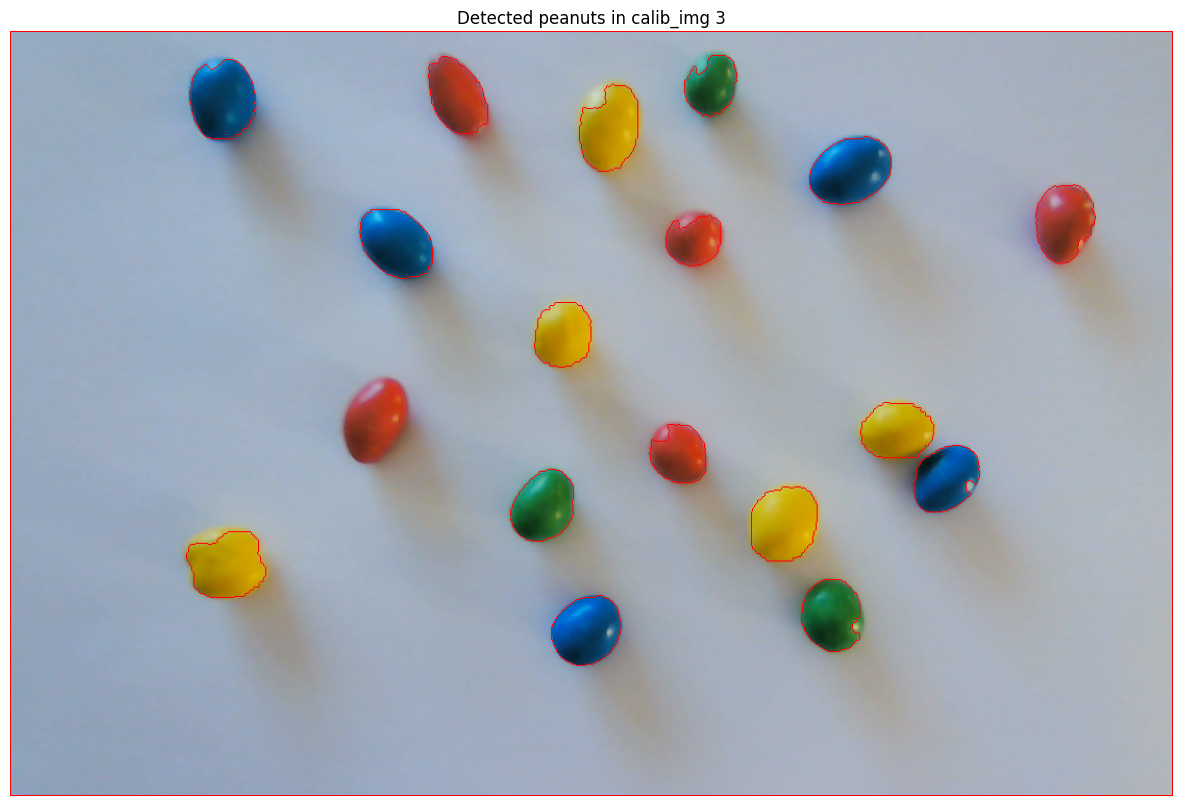

Average area: 2924.853 pixels


In [10]:
# Step 3 - Average peanut area in pixels considering "calib_img 3"
selected_img = "./WhiteBackground/calib_img 3.png"

# Call peanut counter function
marked_img, color_classes = get_number_of_peanuts(mtx, dist, selected_img)

# Display detected peanuts
plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(marked_img, cv2.COLOR_BGR2RGB))
plt.title(f"Detected peanuts in calib_img 3")
plt.axis("off")
plt.show()

total_area = 0
number_peanuts = 0
for color_name in color_classes.keys():
    number_peanuts += color_classes[color_name]["num_peanuts"]
    total_area += sum(color_classes[color_name]["areas"])

print(f"Average area: {total_area / number_peanuts:.3f} pixels")


The peanut identification and classification procedure that was used has the following limitations:
  - when peanuts are exposed to irregular lighting, bright spots and shadows may affect contour detection
  - when a peanut has a smaller size in pixels its specular component may cover most of its area, affecting color detection


In [11]:
# Step 4 - Peanut area and std by color considering "calib_img 2" and "calib_img 3"
selected_imgs = [
    "./WhiteBackground/calib_img 2.png",
    "./WhiteBackground/calib_img 3.png",
]

for selected_img in selected_imgs:
    # Call peanut counter function
    _, color_classes = get_number_of_peanuts(mtx, dist, selected_img)
    print(selected_img)
    for color_name in color_classes.keys():
        avg_area = np.mean(color_classes[color_name]["areas"]) * (mm_px_ratio**2)
        std_area = np.std(color_classes[color_name]["areas"]) * (mm_px_ratio**2)
        print(f"\n\t{color_name} peanuts:")
        print(f"\t\tarea = {avg_area:.2f} mm²\n\t\tstd = {std_area:.2f} mm²")

    print("\n---------\n")

./WhiteBackground/calib_img 2.png

	blue peanuts:
		area = 259.05 mm²
		std = 13.12 mm²

	yellow peanuts:
		area = 241.07 mm²
		std = 35.78 mm²

	red peanuts:
		area = 189.60 mm²
		std = 39.28 mm²

---------

./WhiteBackground/calib_img 3.png

	blue peanuts:
		area = 251.33 mm²
		std = 22.35 mm²

	green peanuts:
		area = 195.55 mm²
		std = 35.69 mm²

	yellow peanuts:
		area = 234.83 mm²
		std = 28.47 mm²

	red peanuts:
		area = 183.67 mm²
		std = 38.13 mm²

---------



**Image 2:**

| Color  | Area (mm²) | Standard deviation (mm²) |
|--------|:----------:|:------------------------:|
| Blue   |   259.05   |          13.12           |
| Yellow |   241.07   |          35.78           |
| Red    |   189.58   |          39.27           |



**Image 3:**

| Color  | Area (mm²) | Standard deviation (mm²) |
|--------|:----------:|:------------------------:|
| Blue   |   251.33   |          22.35           |
| Yellow |   234.83   |          28.47           |
| Red    |   183.67   |          38.13           |
| Green  |   195.55   |          35.69           |



The peanut identification and classification procedure that was used has the following limitations:
  - when peanuts are exposed to irregular lighting, bright spots and shadows may affect contour detection
  - when a peanut has a smaller size in pixels its specular component may cover most of its area, affecting color detection


d) (5 points) Consider the images retrieved from a Grey Background and repeat the previous point without defining a region of interest.